* Writer : Jesoon Kang, Chung-Ang University
* last-modified date : May 20, 2020

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import display, Math, Latex


file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

In [3]:
#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

In [4]:
#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)


In [5]:
#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1


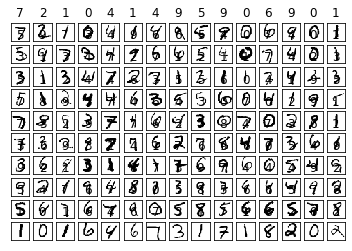

In [10]:
#
# plot first 150 images out of 10,000 with their labels
#
f1 = plt.figure(1)

for i in range(150):

    label       = list_label[i]
    im_vector   = list_image[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(10, 15, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()

In [73]:
train_data = list_image[:,:6000]
train_label = list_label[:6000]
print(train_label.shape)
print(train_label)
test_data = list_image[:,6000:]
test_label = list_label[6000:]

# 6000 x 174
train_data = torch.DoubleTensor(train_data).T


l1_size = 196
l2_size = 49
output_size = 10

data_size = len(train_data)
feature_size = len(train_data.T)

theta_1 = torch.ones([feature_size+1,l1_size],dtype=torch.double)
theta_2 = torch.ones((l1_size+1,l2_size),dtype = torch.double)
theta_3 = torch.ones((l2_size+1,output_size), dtype = torch.double)

bias_0 = torch.ones((data_size,1),dtype=torch.double)
bias_1 = torch.ones((data_size,1),dtype=torch.double)
bias_2 = torch.ones((data_size,1),dtype=torch.double)



input_with_bias = torch.cat((train_data,bias_0),1)
layer_1 = torch.matmul(input_with_bias,theta_1)
act_layer_1 = 1 / (1 + torch.exp(-layer_1))

act_layer_1_with_bias = torch.cat((act_layer_1,bias_1),1)

layer_2 = torch.matmul(act_layer_1_with_bias,theta_2)
act_layer_2 = 1 / (1+torch.exp(-layer_2))
act_layer_2_with_bias = torch.cat((act_layer_2,bias_2),1)

output_layer = torch.matmul(act_layer_2_with_bias,theta_3)
act_output_layer = 1 / (1 + torch.exp(-output_layer))

print(act_output_layer.shape)


(6000,)
[7 2 1 ... 5 1 7]
torch.Size([6000, 10])


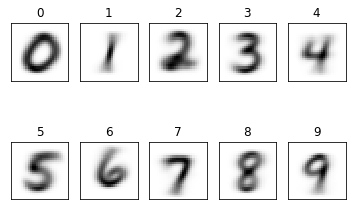

In [9]:
#
# plot the average image of all the images for each digit
#
f2 = plt.figure(2)

im_average  = np.zeros((size_row * size_col, 10), dtype=float)
im_count    = np.zeros(10, dtype=int)

for i in range(num_image):

    im_average[:, list_label[i]] += list_image[:, i]
    im_count[list_label[i]] += 1

for i in range(10):

    im_average[:, i] /= im_count[i]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()

In [2]:
#
# make a matrix each column of which represents an images in a vector form 
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)
count = 0

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])

    list_label[count]       = label
    list_image[:, count]    = im_vector    
    
    count += 1
    
avg_imgs = {}

In [3]:
# Calculate the Average Image for Each Digit
for i in range(0,10) :
    list_label_image = list_image[:,list_label == i]
    m = list_label_image.shape[1]
    avg_image = list_label_image.mean(axis=1)
    avg_imgs[i] = avg_image.reshape((size_row, size_col))

* Assign random values from the normal distribution $\mathcal{N}(0, 1)$ with mean 0 and standard deviation 1 to the weights of the fully connected layer using a logistic unit without a bias

In [4]:
size_layer_1 = 10
thetas_to_layer_1 = torch.DoubleTensor(size_row*size_col,size_layer_1).normal_(0,1)

* Compute the forward propagation and take the average of the output values for the images of the same label

In [5]:
avg_outputs = {}
for i in range(0,10) :
    
    list_label_vector = list_image[:,list_label==i]
    m = list_label_vector.shape[1]

    data = torch.DoubleTensor(list_label_vector).T
    y_layer_1 = torch.matmul(data,thetas_to_layer_1)
    z_output = 1 /  (1+torch.exp(-y_layer_1))

    avg_outputs[i] = z_output.mean()

# Plot the average image

* Plot the average images of the same label for each digit
* Arrange the subplots in 2x5 array for the 10 average images and present the label at the title of each subplot in the increasing order of the label

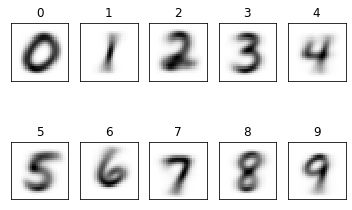

In [6]:
# Plot the Average Image for Each Digit
for i in range(0,10) :
    im_matrix = avg_imgs[i]
    plt.subplot(2,5,i+1)
    plt.title(i)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')
    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()

# Present the output of the neural network with random weights

* Present the average values for each label in the increasing order of the label

In [7]:
for i in range(0,10) :
    print("Average Output on label {:d} : {:.5f}".format(i,avg_outputs[i]))

Average Output on label 0 : 0.58065
Average Output on label 1 : 0.39304
Average Output on label 2 : 0.49864
Average Output on label 3 : 0.40694
Average Output on label 4 : 0.44703
Average Output on label 5 : 0.42002
Average Output on label 6 : 0.44267
Average Output on label 7 : 0.46279
Average Output on label 8 : 0.43438
Average Output on label 9 : 0.40086
